# Hextraj tutorial

We'll learn how to

- [x] create a projection
- [x] label positions along a trajectory
- [x] aggregate data within the labelled hexagons
- [x] calculate a connectivity matrix for the hexagons
- [x] Aggregate gridded data into hexes
- [x] Aggregate point-cloud data into hexes

## Imports

In [1]:
from hextraj import HexProj

import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
from dask.distributed import Client

In [2]:
dask_client = Client(n_workers=2, threads_per_worker=2)
dask_client

2023-03-01 13:08:09,190 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-gbrw16m_', purging
2023-03-01 13:08:09,191 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-koaffft8', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 4,Total memory: 7.77 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35759,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 7.77 GiB
Comm: tcp://127.0.0.1:34667,Total threads: 2
Dashboard: http://127.0.0.1:43373/status,Memory: 3.89 GiB
Nanny: tcp://127.0.0.1:39235,


## The HexProj object

By default, it uses the [Lambert Azimuthal Equal-Area Projection](https://en.wikipedia.org/wiki/Lambert_azimuthal_equal-area_projection) centered about a location `(lon_origin, lat_origin)`, which needs to be specified by the user.
It also uses a hex size in meters (which is the distance of the corners from the center of the hex), and defaults to a "flat top" orientation of the hexed.

For details, check
```python
HexProj?
```

## Load some trajectories

There's an example dataset included in the repo here. It covers the North-Sea region and has 19-day-long trajectories with one timestep / day.

In [3]:
ds_traj = xr.open_dataset("../data/trajs/nwshelf.nc", chunks={"traj": 1000, "obs": 10})
ds_traj

<xarray.Dataset>
Dimensions:      (traj: 5000, obs: 20)
Dimensions without coordinates: traj, obs
Data variables:
    time         (traj, obs) datetime64[ns] dask.array<chunksize=(1000, 10), meta=np.ndarray>
    trajectory   (traj, obs) float64 dask.array<chunksize=(1000, 10), meta=np.ndarray>
    lon          (traj, obs) float32 dask.array<chunksize=(1000, 10), meta=np.ndarray>
    lat          (traj, obs) float32 dask.array<chunksize=(1000, 10), meta=np.ndarray>
    z            (traj, obs) float32 dask.array<chunksize=(1000, 10), meta=np.ndarray>
    temperature  (traj, obs) float32 dask.array<chunksize=(1000, 10), meta=np.ndarray>
    salinity     (traj, obs) float32 dask.array<chunksize=(1000, 10), meta=np.ndarray>
    land         (traj, obs) float32 dask.array<chunksize=(1000, 10), meta=np.ndarray>
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.1
    parcels_mesh:           spherical

# A hex projector

We need a good center longitude and latitude and a good size of the hexes.
The height (North-South) of the flat hexes is $\sqrt{3}\cdot{\rm size}$.
We chose approx. 10 hexes in the meridional direction.
(This is fewer hexes than we'll want in a realistic application. But as we only have 5000 test trajectories here, we want some statistics.)

In [4]:
lon_origin = (ds_traj.lon.min() + ds_traj.lon.max()).compute().data[()] / 2
lat_origin = (ds_traj.lat.min() + ds_traj.lat.max()).compute().data[()] / 2
hex_size_meters = (
    (ds_traj.lat.max() - ds_traj.lat.min()).compute().data[()]
    * 111e3 / 10 / (3 ** 0.5)
)

print(lon_origin, "E\t", lat_origin, "N")
print(hex_size_meters, "meters")

-2.9847207069396973 E	 54.37133026123047 N
107296.83755830918 meters


In [5]:
hex_proj = HexProj(
    lon_origin=lon_origin,
    lat_origin=lat_origin,
    hex_size_meters=hex_size_meters,
)

/srv/conda/envs/notebook/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [6]:
print(hex_proj)

HexProj(projection_name='laea', lon_origin=-2.9847207069396973, lat_origin=54.37133026123047, hex_size_meters=107296.83755830918, hex_orientation='flat', )


## Hex labels for each position

We use the method `hex_proj.lon_lat_to_hex_AoS()` for labelling. This method returns an _A_rray _o_f _S_tructures where each element is a 3-element tuple `(q, r, s)` which represent [cube coords on a hexagonal grid](https://www.redblobgames.com/grids/hexagons/#coordinates-cube).

We use `xr.apply_ufunc()` for applying this method to the Xarray data arrays `lon` and `lat` in a parallelized way.

In [7]:
%%time

hex_labels = xr.apply_ufunc(
    hex_proj.lon_lat_to_hex_AoS,
    ds_traj.lon, 
    ds_traj.lat,
    dask="parallelized",
    output_dtypes=[tuple, ],
).rename("hex_labels")

# note that this does not compute anything yet, but just defines the dependencies of the desired output.

CPU times: user 2.83 ms, sys: 851 µs, total: 3.68 ms
Wall time: 3.42 ms


In [8]:
hex_labels

<xarray.DataArray 'hex_labels' (traj: 5000, obs: 20)>
dask.array<transpose, shape=(5000, 20), dtype=object, chunksize=(1000, 10), chunktype=numpy.ndarray>
Dimensions without coordinates: traj, obs

Let's add this to the trajectory dataset:

In [9]:
ds_traj["hex_labels"] = hex_labels
ds_traj

<xarray.Dataset>
Dimensions:      (traj: 5000, obs: 20)
Dimensions without coordinates: traj, obs
Data variables:
    time         (traj, obs) datetime64[ns] dask.array<chunksize=(1000, 10), meta=np.ndarray>
    trajectory   (traj, obs) float64 dask.array<chunksize=(1000, 10), meta=np.ndarray>
    lon          (traj, obs) float32 dask.array<chunksize=(1000, 10), meta=np.ndarray>
    lat          (traj, obs) float32 dask.array<chunksize=(1000, 10), meta=np.ndarray>
    z            (traj, obs) float32 dask.array<chunksize=(1000, 10), meta=np.ndarray>
    temperature  (traj, obs) float32 dask.array<chunksize=(1000, 10), meta=np.ndarray>
    salinity     (traj, obs) float32 dask.array<chunksize=(1000, 10), meta=np.ndarray>
    land         (traj, obs) float32 dask.array<chunksize=(1000, 10), meta=np.ndarray>
    hex_labels   (traj, obs) object dask.array<chunksize=(1000, 10), meta=np.ndarray>
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.1
    parcels_mesh:           spherical

## Hex heat maps

The simplest way to create a heatmap now is to group by the hex labels and then count each position per group.
But `xr.DataArray.groupby()` only really works with numerical values or strings.


In [10]:
from dask import array as darr

In [11]:
%%time

# cast to numpy and chunk up again
unique_hex_labels = darr.unique(ds_traj["hex_labels"].data)
unique_hex_labels = np.sort(unique_hex_labels.compute())
print("raw label array:")
display(unique_hex_labels)
unique_hex_labels = darr.from_array(unique_hex_labels, chunks=(int(len(unique_hex_labels) // 4 + 1), ))

# to xarray
unique_hex_labels =  xr.DataArray(
    unique_hex_labels,
    dims=("unique_hex", ),
    name="unique_hex",
)

print("\nxr DataArray:")
display(unique_hex_labels)

raw label array:


array([(-9223372036854775808, -9223372036854775808, 0), (-6, -2, 8),
       (-6, -1, 7), (-6, 0, 6), (-6, 1, 5), (-6, 2, 4), (-5, -2, 7),
       (-5, -1, 6), (-5, 0, 5), (-5, 1, 4), (-5, 2, 3), (-5, 3, 2),
       (-5, 4, 1), (-5, 5, 0), (-5, 6, -1), (-4, -3, 7), (-4, -2, 6),
       (-4, -1, 5), (-4, 0, 4), (-4, 1, 3), (-4, 2, 2), (-4, 3, 1),
       (-4, 4, 0), (-4, 5, -1), (-4, 6, -2), (-4, 7, -3), (-3, -3, 6),
       (-3, -2, 5), (-3, -1, 4), (-3, 0, 3), (-3, 1, 2), (-3, 2, 1),
       (-3, 3, 0), (-3, 4, -1), (-3, 5, -2), (-3, 6, -3), (-3, 7, -4),
       (-2, -4, 6), (-2, -3, 5), (-2, -2, 4), (-2, -1, 3), (-2, 0, 2),
       (-2, 1, 1), (-2, 2, 0), (-2, 3, -1), (-2, 4, -2), (-2, 5, -3),
       (-2, 6, -4), (-1, -4, 5), (-1, -3, 4), (-1, -2, 3), (-1, -1, 2),
       (-1, 0, 1), (-1, 1, 0), (-1, 2, -1), (-1, 3, -2), (-1, 4, -3),
       (-1, 5, -4), (-1, 6, -5), (0, -5, 5), (0, -4, 4), (0, -3, 3),
       (0, -2, 2), (0, -1, 1), (0, 0, 0), (0, 1, -1), (0, 2, -2),
       (0, 3, -3), (0, 4, -


xr DataArray:


<xarray.DataArray 'unique_hex' (unique_hex: 103)>
dask.array<array, shape=(103,), dtype=object, chunksize=(26,), chunktype=numpy.ndarray>
Dimensions without coordinates: unique_hex

CPU times: user 88.1 ms, sys: 12.2 ms, total: 100 ms
Wall time: 381 ms


In [12]:
pos_per_hex = (ds_traj.hex_labels == unique_hex_labels).sum("traj")
pos_per_hex

<xarray.DataArray (obs: 20, unique_hex: 103)>
dask.array<sum-aggregate, shape=(20, 103), dtype=int64, chunksize=(10, 26), chunktype=numpy.ndarray>
Dimensions without coordinates: obs, unique_hex

Note that along the way, we have created a much larger but virtual array, which we never fully know at the same time, however:

In [13]:
(ds_traj.hex_labels == unique_hex_labels)

<xarray.DataArray (traj: 5000, obs: 20, unique_hex: 103)>
dask.array<eq, shape=(5000, 20, 103), dtype=bool, chunksize=(1000, 10, 26), chunktype=numpy.ndarray>
Dimensions without coordinates: traj, obs, unique_hex

In [14]:
pos_per_hex

<xarray.DataArray (obs: 20, unique_hex: 103)>
dask.array<sum-aggregate, shape=(20, 103), dtype=int64, chunksize=(10, 26), chunktype=numpy.ndarray>
Dimensions without coordinates: obs, unique_hex

Now, we need the positions of each of the unique hexes:

In [15]:
from hextraj.aux import hex_AoS_to_SoA

In [16]:
_lon, _lat = hex_proj.hex_to_lon_lat_SoA(hex_AoS_to_SoA(unique_hex_labels.data.compute()))
pos_per_hex = pos_per_hex.assign_coords(
    lon=("unique_hex", _lon),
    lat=("unique_hex", _lat),
)
pos_per_hex

<xarray.DataArray (obs: 20, unique_hex: 103)>
dask.array<sum-aggregate, shape=(20, 103), dtype=int64, chunksize=(10, 26), chunktype=numpy.ndarray>
Coordinates:
    lon      (unique_hex) float64 nan -15.32 -15.71 -16.13 ... 8.234 9.529 10.65
    lat      (unique_hex) float64 nan 45.27 46.92 48.56 ... 58.91 54.56 57.84
Dimensions without coordinates: obs, unique_hex

In [17]:
import cartopy
from matplotlib import pyplot as plt

In [18]:
# fig, ax = plt.subplots(1, 1, subplot_kw={
#     "projection": cartopy.crs.Stereographic(
#         central_latitude=hex_proj.lat_origin,
#         central_longitude=hex_proj.lon_origin,
#     ),
# })

# pos_per_hex.mean("obs").to_dataset(name="pos_per_hex").plot.scatter(
#     x="lon", y="lat", hue="pos_per_hex",
#     vmin=0, vmax=100,
#     s=40,
#     ax=ax,
#     transform=cartopy.crs.PlateCarree(),
# )

# ax.coastlines();

## Connectivity

Let's check connectivity from the first to the last time step.

In [19]:
%%time

hex_start = ds_traj.hex_labels.isel(obs=0, drop=True).to_dataset(name="hex_start")
hex_end = ds_traj.hex_labels.isel(obs=slice(-2, None), drop=True).to_dataset(name="hex_end")
ones = xr.ones_like(hex_start.hex_start, dtype="int").to_dataset(name="ones")

merged = xr.merge((hex_start, hex_end, hex_end, ones))
display(merged)

merged_ddf = merged.to_dask_dataframe()
display(merged_ddf)

connection_count = merged_ddf.groupby(["hex_start", "hex_end"])["ones"].sum().compute()
display(connection_count)

<xarray.Dataset>
Dimensions:    (traj: 5000, obs: 2)
Dimensions without coordinates: traj, obs
Data variables:
    hex_start  (traj) object dask.array<chunksize=(1000,), meta=np.ndarray>
    hex_end    (traj, obs) object dask.array<chunksize=(1000, 2), meta=np.ndarray>
    ones       (traj) int64 dask.array<chunksize=(1000,), meta=np.ndarray>

,traj,obs,hex_start,hex_end,ones
npartitions=5,,,,,
0,int64,int64,object,object,int64
2000,...,...,...,...,...
...,...,...,...,...,...
8000,...,...,...,...,...
9999,...,...,...,...,...


hex_start    hex_end                                        
(-6, -2, 8)  (-6, -2, 8)                                         2
(-6, -1, 7)  (-9223372036854775808, -9223372036854775808, 0)    28
             (-6, -1, 7)                                        13
             (-5, -2, 7)                                        19
             (-5, -1, 6)                                         6
                                                                ..
(1, 2, -3)   (3, 1, -4)                                          1
(1, 3, -4)   (0, 4, -4)                                          1
(2, 1, -3)   (2, 0, -2)                                          4
(2, 4, -6)   (2, 3, -5)                                          4
(4, -1, -3)  (5, 0, -5)                                          2
Name: ones, Length: 490, dtype: int64

CPU times: user 387 ms, sys: 35.3 ms, total: 423 ms
Wall time: 824 ms


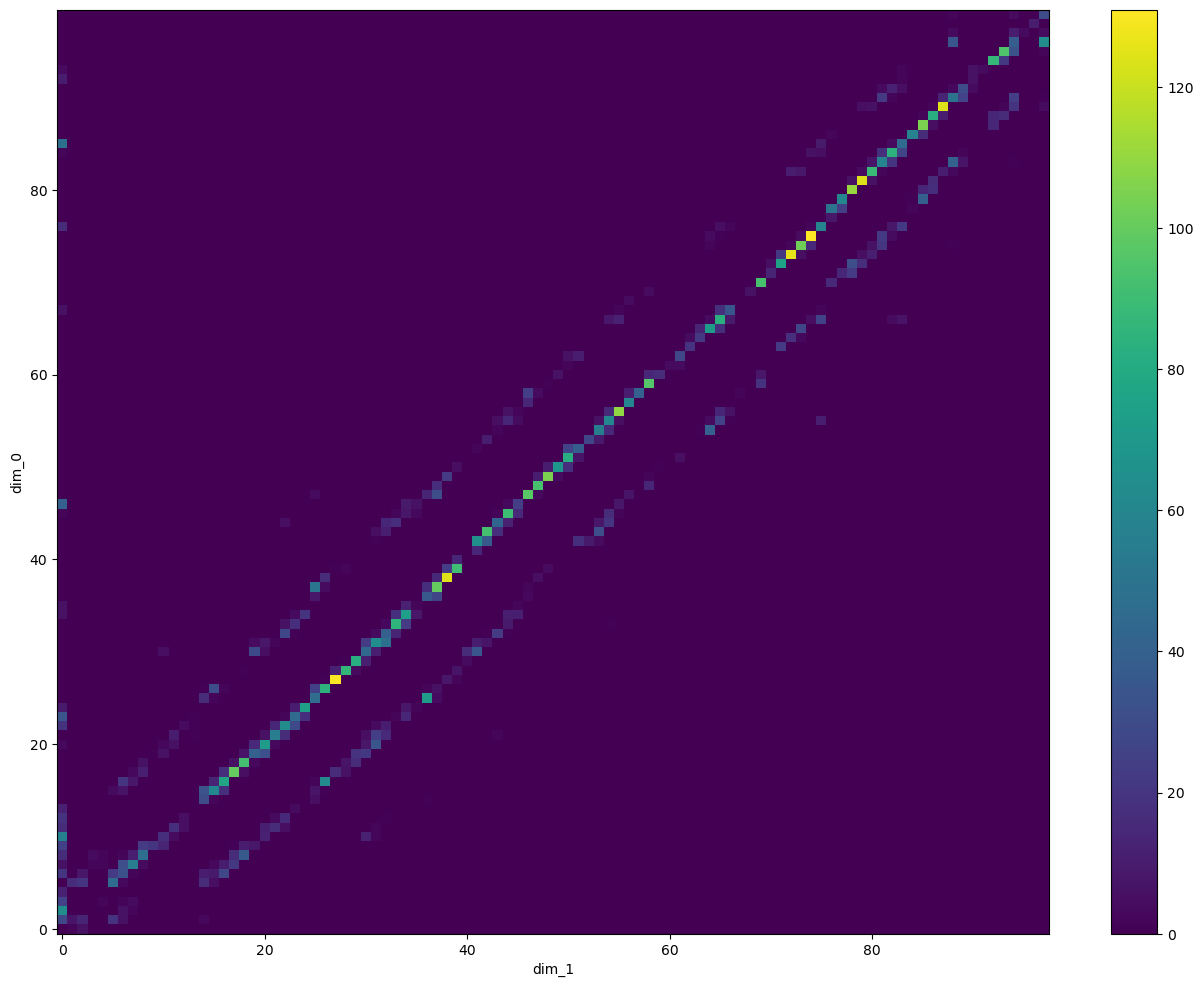

In [21]:
xr.DataArray(np.array(connection_count.rename("count").to_frame().unstack(-1).fillna(0))).plot(size=12)